### Volume analysis through Nup133 labeling
Script that aims to analyze cell microscopy data in order to gain insight into cell volume dynamics.
Made by Olle de Jong, based on preexisting microscopy analysis files by Luc-Alban Vuillemenot.

In [187]:
""" Imports """
import os
import random
import re
import copy
from math import pi, sin, cos
import pandas as pd
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.ndimage import center_of_mass, binary_erosion
import seaborn as sns
from skimage import measure
from skimage.io import imread, imshow
from skimage.filters import threshold_local, threshold_otsu, try_all_threshold, threshold_minimum, threshold_yen, rank
from skimage.morphology import remove_small_objects, disk
import bottleneck as bn
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [191]:
""" Globals """
# globally define bottleneck 'nanmean' estimator
nan_mean = bn.nanmean

# IMPORTANT PATHS
# Data files
data_dir = "/Users/olledejong/Studie/MSc Biology/Research Project V1/Code and data/Data"
tiff_files_dir = data_dir + "/processed_tiffs_nup133/"  # relative path from data directory to tiff directory
img_output_dir = data_dir + "/Output/"  # relative path from data directory to image output directory
# Data sheets
budj_data_folder = data_dir + "/Other/Nup133/BudJ"  # folder that holds the BudJ info on all cells
budding_data_path = data_dir + "/Other/Nup133/buddings.txt"  # budding events
kario_data_path = data_dir + "/Other/Nup133/kariokinesis.txt"  # kariokinesis events

# thresholding globals
scaling_factor = 0.16  # microns per pixel ---> 100x objective
bloc_size_frac_to_use = 0.09
offset_to_use = -50

Now we define a couple of functions that will be used throughout the analysis process. There's a function for time conversion from 'frame' time to real time, since one frame is equal to 5 real time minutes. For function descriptions, see the function's docstring.

In [61]:
def ellipse(t, cell_data, scaling_factor):
    """
    Define the function that can extract parameters of the ellipse using the data
    Function to extract parameters of the ellipse from the BudJ table
    """
    data_at_frame = cell_data[cell_data["TimeID"] == t]
    x_pos = float(data_at_frame['x']) / scaling_factor
    y_pos = float(data_at_frame['y']) / scaling_factor
    majorR = float(data_at_frame["Major R"]) / scaling_factor
    minorR = float(data_at_frame["Minor r"]) / scaling_factor
    angle = float(data_at_frame['Angle']) * (pi / 180)  # convert to radians
    return x_pos, y_pos, majorR, minorR, angle

def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

def plot_from_list(fig_title, data_list, xlim, ylim, save_fig=False, filename="test.png"):
    """
    Given a dictionary that holds image data, plot those in one figure
    """
    if save_fig:
        plt.ioff()
    fig = plt.figure(
        figsize=(4 * len(data_list), 4.2),
        edgecolor="black",
        frameon=True,
        facecolor="white",
        layout="tight"
    ).suptitle(fig_title, fontsize=14, y=1)
    i = 1
    for data in data_list:
        subplt = plt.subplot(1, len(data_list), i)
        subplt.set_title(label=data[0], y=1.02)
        plt.imshow(data[1], cmap="hot")
        subplt.grid(False)
        plt.xlim(xlim)
        plt.ylim(ylim)
        i += 1
    if save_fig:
        plt.savefig(filename)
        plt.close(fig)
    else:
        plt.show()

Now that we've loaded some handy functions, we can proceed with creating a function for loading BudJ data. One file contains the information for one position which include one through three/four individual cells.

In [34]:
"""
Given a position, the data for the cells in position are loaded from the by BudJ created CSV file.
"""
def load_budj_data_for_pos(pos):
    cell_data = pd.read_csv(f"{budj_data_folder}/BudJ on 2022_12_06_nup133_yegfp_xy{pos}.nd2.tif Cell data .csv")
    cell_data = cell_data[cell_data.columns[1:]]

    return cell_data

Now, lets load the budding and karyoginesis event timepoints from the by BudJ produced files.

In [5]:
"""
Load the data from the kario/budding event files
"""
events_files = {"budding": budding_data_path, "kariokinesis": kario_data_path}

budding_events = {}
kario_events = {}
for event_type in events_files:  # for either budding or kariokinesis events
    opened_file = open(events_files[event_type])  # open the file
    events = {}  # temp storage object
    for line in opened_file:  # every line in the file is a cell
        if line == "\n":
            continue
        # process the two parts of the line by removing characters
        parts = line.split(':')
        cell_id = parts[0].replace("\"", "")  # first part of the line is the individual cell
        timepoints = re.sub('[\,\[\]]', "", parts[1])  # second part are the timepoints
        # split timepoints on space to capture them in a list
        events[cell_id] = timepoints.split(" ")

    # save the events to the right dictionary
    if event_type == "budding":
        budding_events = events
    if event_type == "kariokinesis":
        kario_events = events
    opened_file.close()

print(f"There are budding events for {len(budding_events)} cells")
print(f"There are karyokinesis events for {len(kario_events)} cells")

There are budding events for 50 cells
There are karyokinesis events for 50 cells


Lets also define a function, since it will be used multiple times, for getting the whole cell mask based on the BudJ data.

In [50]:
def get_whole_cell_mask(t, single_cell_data, image_shape):
    # get/calculate the ellipse information
    x_pos, y_pos, majorR, minorR, A = ellipse(t, single_cell_data, scaling_factor)

    y_dim, x_dim = image_shape  # get the dimensions (512x512)

    # create an ogrid that helps us select/'mask' the info we want
    row, col = np.ogrid[:y_dim, :x_dim]

    # get the mask of the whole cell
    return (
            (
                (((col - x_pos) * cos(A) + (row - y_pos) * sin(A)) ** 2) / (majorR ** 2)
                 +
                (((col - x_pos) * sin(A) - (row - y_pos) * cos(A)) ** 2) / (minorR ** 2) - 1
            ) # if this sum
            < 0  # is smaller than zero
    ), x_pos, y_pos

### Whole cell masking using BudJ data

There are 2 cells in position 01. Lets take a look at cell pos01_1.


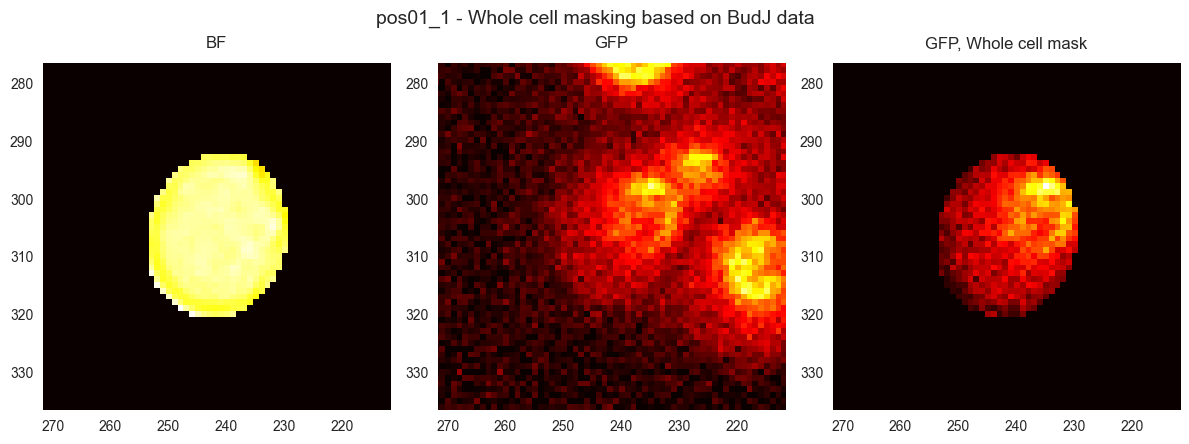

In [70]:
"""
The image channels are split, where after the whole cell mask is created. That, and the
two original channels are plotted, which makes them visually comparable.
"""
# let's take position 01 as example
pos = "01"
# number of cells in the current position (list comprehension)
cell_data = load_budj_data_for_pos(pos)
num_cells = cell_data.Cell.nunique()

# This image variable is a 4 dimensional array. The outer array of 150 length holds matrices of
# 512 by 512 pixels. These each hold 2 values. Index 0: BF channel, index 1: GFP channel
image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif"))

# let's take cell 2 of position 01 as example
cell = 1
cell_pos = f"pos{pos}_{cell}"
print(f"There are {num_cells} cells in position {pos}. Lets take a look at cell {cell_pos}.")

# get the data for the single cell
single_cell_data = cell_data[cell_data["Cell"] == cell]

t = 16
t_in_tiff = t - 1  # skew the time by one

imageBF = image[t_in_tiff, 0, :, :]
imageGFP = image[t_in_tiff, 1, :, :]

# get the whole cell mask
whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

# plot the regular BF and GFP channels and compare this to the masked whole cell (based on ImageJ data)
to_plot = [
    ["BF", imageBF * whole_cell_mask, "hot"],
    ["GFP", imageGFP, "hot"],
    ["GFP, Whole cell mask",  imageGFP * whole_cell_mask, "hot"]
]
plot_from_list(f"{cell_pos} - Whole cell masking based on BudJ data", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), False)

### Comparing multiple thresholding methods
Here we compare multiple thresholding methodologies. This is done on multiple randomly chosen cells. Local thresholding generates a threshold mask image based on local pixel neighborhood. The algorithm behind Otsu thresholding searches for the threshold that minimizes the intra-class variance to essentially split the pixels into two classes.

Randomly picked positions 4 and 19 to perform thresholding on.
Working with pos04
39


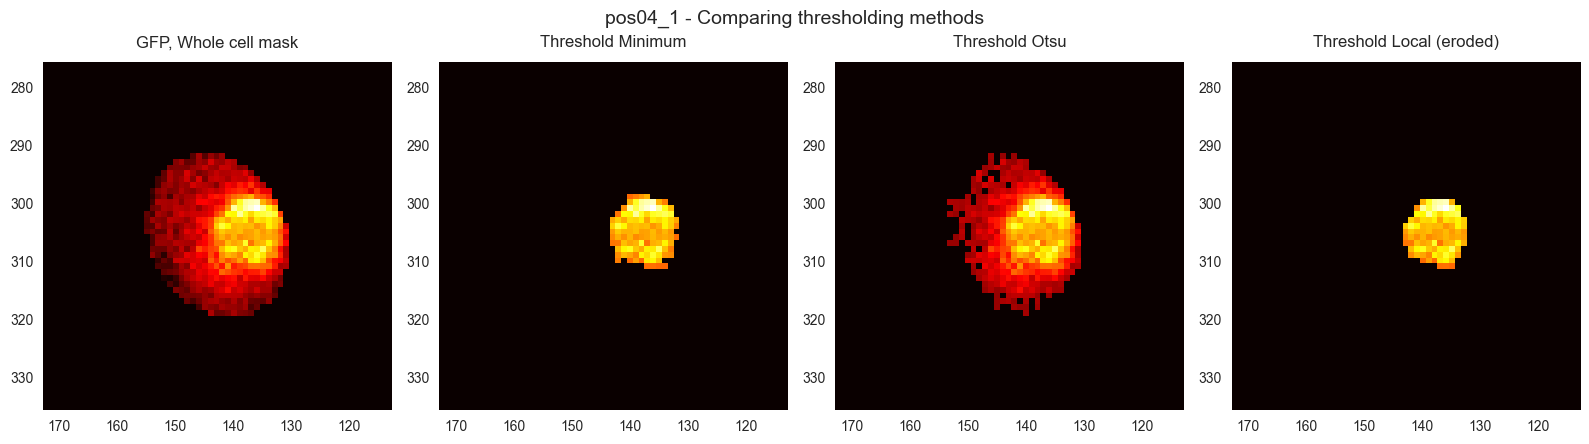

47


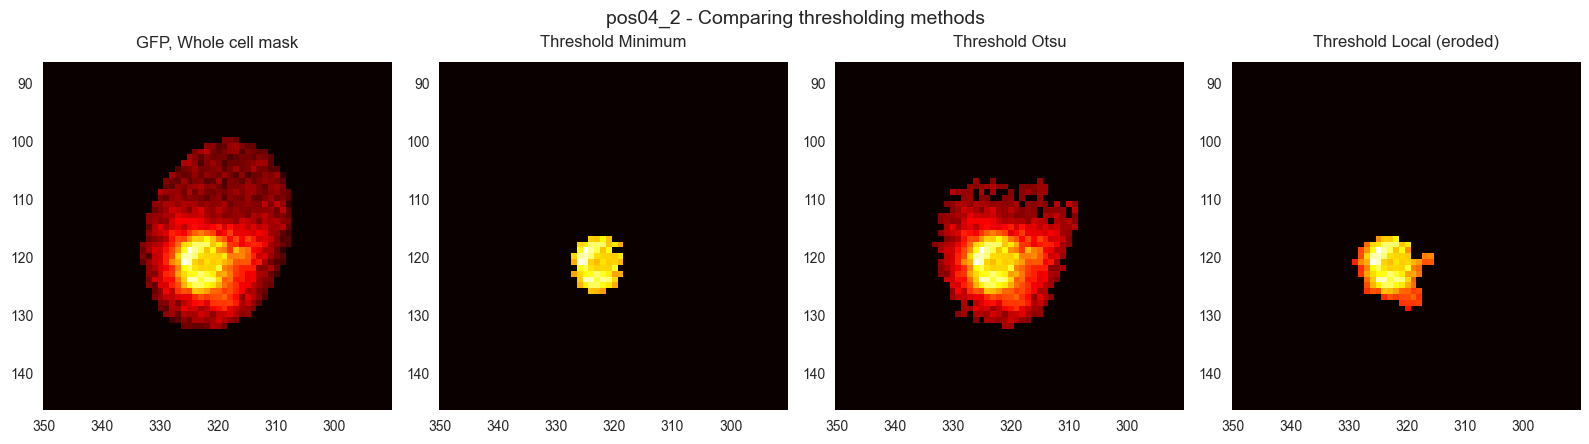

Working with pos19
53


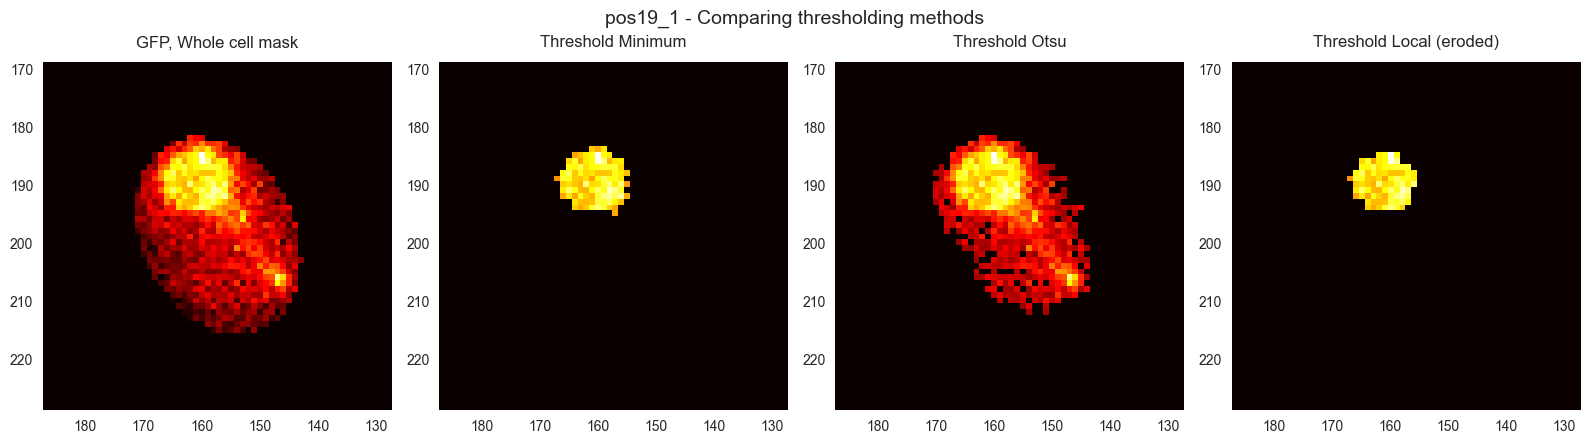

In [172]:
random_positions = random.sample(range(1,20), 2)
print(f"Randomly picked positions {random_positions[0]} and {random_positions[1]} to perform thresholding on.")

for pos in random_positions:
    if pos < 10:
        pos = f"0{pos}"
    print(f"Working with pos{pos}")
    # load the image
    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif"))
    cell_data = load_budj_data_for_pos(pos) # load the cell data for this position
    unique_cells = cell_data.Cell.unique() # amount of cells in this position

    for cell in unique_cells:
        single_cell_data = cell_data[cell_data["Cell"] == cell]  # get the data for the single cell

        # get the first available frame
        t = single_cell_data['TimeID'].iloc[0]
        t_in_tiff = t - 1

        imageBF = image[t_in_tiff, 0, :, :]
        imageGFP = image[t_in_tiff, 1, :, :]

        whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

                            # PERFORM DIFFERENT THRESHOLD METHODS
        num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
        bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

        # adaptive thresholding will be performed not on all image but on a fraction of it which includes the cell
        imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the GFP channel that is within the cell mask

        # thresholding for getting the nuclear mask
        nucl_thresh_mask_local = threshold_local(  # local thresholding
            image=imageGFP_cell_mask,
            block_size=bloc_size_cell_size_dependent,
            method='gaussian',
            offset=offset_to_use,
            mode='reflect'
        )
        nucl_thresh_mask_otsu = threshold_otsu(imageGFP_cell_mask)  # perform otsu thresholding
        nucl_thresh_mask_minimum = threshold_minimum(imageGFP_cell_mask)  # perform minimum thresholding

        # keep the nucleus pixels that are greater than the local threshold (either with or without erosion)
        imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
        imageGFP_nuc_mask_minimum = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_minimum)
        imageGFP_nuc_mask_otsu = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_otsu)

        imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))

        to_plot = [
            ["GFP, Whole cell mask",  imageGFP * whole_cell_mask],
            ["Threshold Minimum", imageGFP * imageGFP_nuc_mask_minimum],
            # ["Threshold Local", imageGFP * imageGFP_nuc_mask_local],
            ["Threshold Otsu", imageGFP * imageGFP_nuc_mask_otsu],
            ["Threshold Local (eroded)", imageGFP * imageGFP_nuc_mask_local_eroded]
        ]

        plot_from_list(f"pos{pos}_{cell} - Comparing thresholding methods", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30))

Notes: local thresholding seems, after erosion, seems to give the most accurate fit to the nucleus. Minimum thresholding is also performing well, but as you can tell, when the nuclear intensity is not sufficiently high, the minimum method does not result in the desired result at all. In this case, it seems unreliable because of its all-or-nothing nature. Once the piece of investigative code above is run a couple of times, we find that thresholding with erosion performs best.

### Fitting the nuclear ellipse
Using the best thresholding method chosen from options above (Local (eroded) for now)

In [170]:
"""
Function that generates and fits the ellipse using the opencv package. It takes a nuclear mask as argument.
"""
def get_ellipse(cell_name, imageRFP, nuc_mask):
    mask = imageRFP * nuc_mask
    thresh = mask.astype(np.uint8)  # change type to uint8

    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    # if there is a contour found
    if len(contours) > 0:
        return cv2.fitEllipse(max(contours, key=len))
    else:
        print(f"There was no contour found for cell {cell_name}")

Using the above created get_ellipse function, we now plot the original RFP channel, the two versions of nuclear thresholding (non-eroded and eroded) and the fitted ellipse all in one figure to provide an overview of the performance.

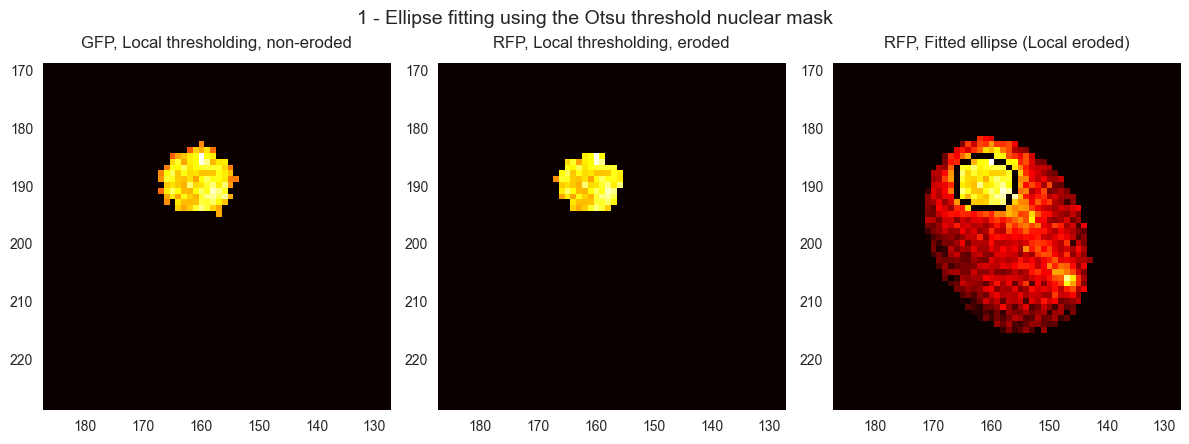

The major and minor axes of the ellipse are 10.53715991973877 and 9.454000473022461, respectively
The volume of the ellipse is 4170.957918626921


In [173]:
# TODO Only for the last processed cell above
# get the nuclear ellipse
(x, y), (MA, ma), angle = get_ellipse(cell, imageGFP, imageGFP_nuc_mask_local_eroded)  # use imageRFP and nuc_mask_otsu from last plotted cell above
cv2_ellipse = ((x, y), (MA, ma), angle)

# plot side by side
to_plot = [
    ["GFP, Local thresholding, non-eroded", imageGFP * imageGFP_nuc_mask_local],
    ["GFP, Local thresholding, eroded", imageGFP * imageGFP_nuc_mask_local_eroded],
    ["GFP, Fitted ellipse (Local eroded)", cv2.ellipse(imageGFP * whole_cell_mask, cv2_ellipse, (0, 0, 0), 1)] # arguments: 1, image data 2, fitted ellipse 3, color (BGR), 4, linewidth
]
plot_from_list(f"pos{pos}_{cell} - Ellipse fitting using the Local threshold nuclear mask", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), False)

print(f"The major and minor axes of the ellipse are {ma} and {MA}, respectively.")
print(f"The volume of the ellipse is {4/3 * pi * MA * ma * ((ma + MA) / 2)}") # where the third axis is the average of the major and minor axes

### Let's look at thresholding performance over time

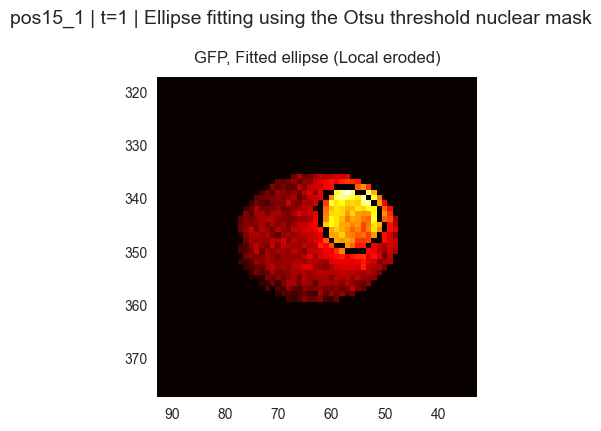

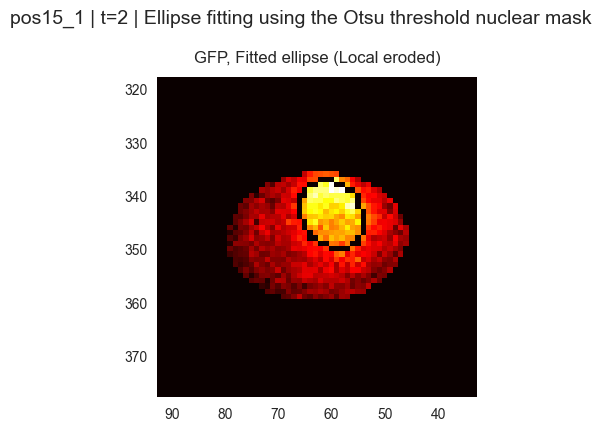

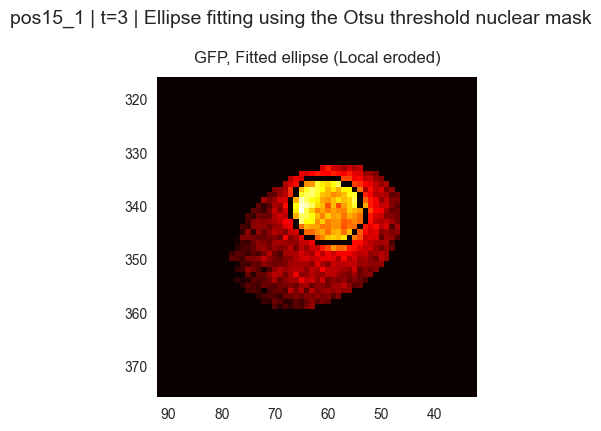

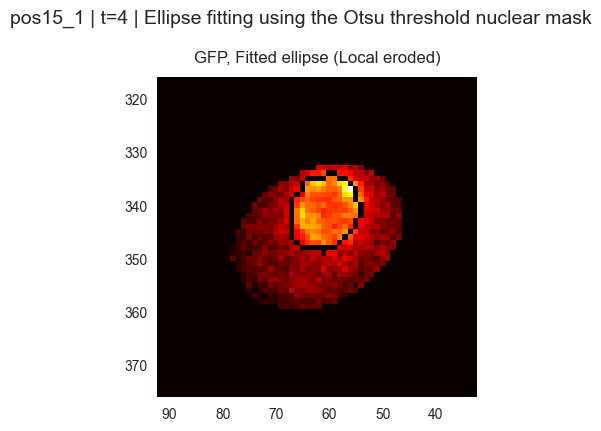

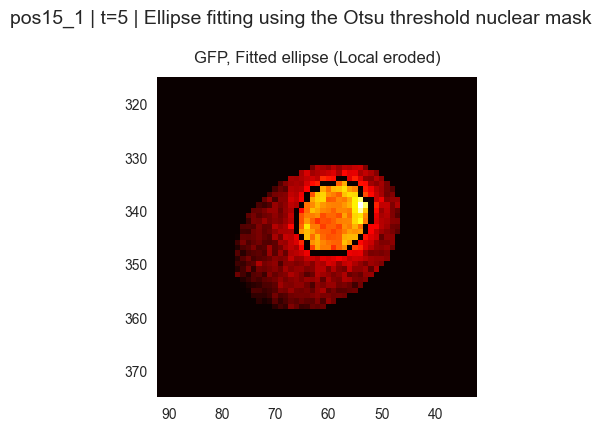

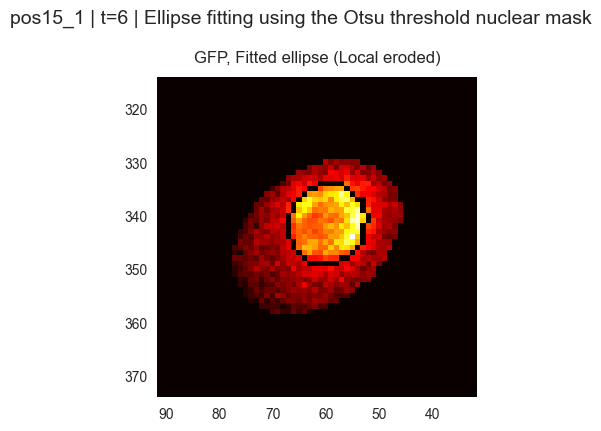

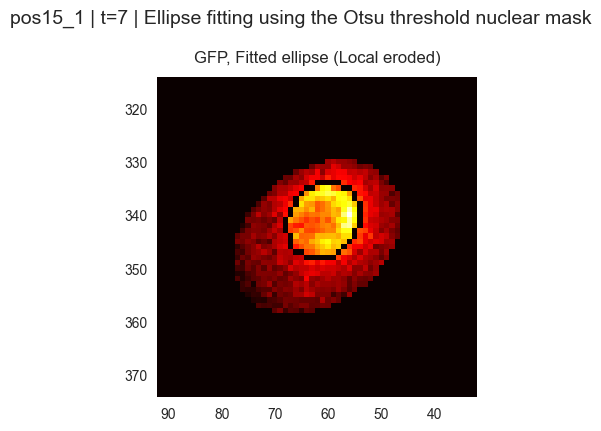

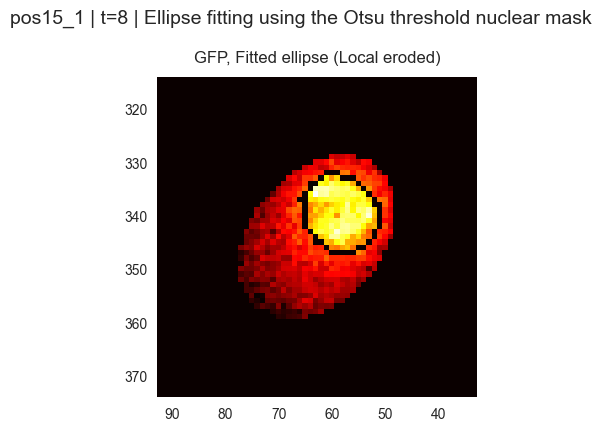

KeyboardInterrupt: 

In [202]:
fitted_ellipses = []
pos = "15"
image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif"))
cell_data = load_budj_data_for_pos(pos) # load the cell data for this position
unique_cells = cell_data.Cell.unique() # amount of cells in this position
single_cell_data = cell_data[cell_data["Cell"] == unique_cells[0]]

first_t = single_cell_data['TimeID'].iloc[0]  # first time-point in data
last_t = single_cell_data['TimeID'].iloc[-1]  # second time-point in data

timerange = [i for i in range(first_t, last_t)]
for t in timerange:
    # skew the time by one for tiff dataframe
    t_in_tiff = t - 1

    # get/calculate the ellipse information
    x_pos, y_pos, majorR, minorR, A = ellipse(t, single_cell_data, scaling_factor)

    imageGFP = image[t_in_tiff, 1, :, :] # get the GFP data
    y_dim, x_dim = imageGFP.shape  # get the dimensions

    # create an ogrid that helps us select/'mask' the info we want
    row, col = np.ogrid[:y_dim, :x_dim]

    # get the mask of the whole cell
    whole_cell_mask = (
        (
            (((col - x_pos) * cos(A) + (row - y_pos) * sin(A)) ** 2) / (majorR ** 2)
             +
            (((col - x_pos) * sin(A) - (row - y_pos) * cos(A)) ** 2) / (minorR ** 2) - 1
        ) # if this sum
        < 0  # is smaller than zero
    )

    imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the RFP channel that is within the cell mask

    num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
    bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

    nucl_thresh_mask_local = threshold_local(  # local thresholding
        image=imageGFP_cell_mask,
        block_size=bloc_size_cell_size_dependent,
        method='gaussian',
        offset=offset_to_use,
        mode='reflect'
    )
    imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
    imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))

    try:
        (x, y), (MA, ma), angle = get_ellipse(cell, imageGFP, imageGFP_nuc_mask_local_eroded)
        cv2_ellipse = ((x, y), (MA, ma), angle)
    except TypeError:
        print(f"Failed to get ellipse for {pos}_{cell} at t={t}")

    fitted_ellipses.append((t, cv2.ellipse(imageGFP * whole_cell_mask, cv2_ellipse, (0, 0, 0), 1)))
    # # plot side by side
    to_plot = [
        ["GFP, Fitted ellipse (Local eroded)", cv2.ellipse(imageGFP * whole_cell_mask, cv2_ellipse, (0, 0, 0), 1)] # arguments: 1, image data 2, fitted ellipse 3, color (BGR), 4, linewidth
    ]
    plot_from_list(f"pos{pos}_{cell} | t={t} | Ellipse fitting using the Otsu threshold nuclear mask", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), False)

In [199]:
# amount_rows = round(len(fitted_ellipses) / 5)
# amount_columns = 5
# plt.ioff()
# fig, ax = plt.subplots(amount_rows, amount_columns, figsize=(amount_rows * 2, 30))
# # fig.suptitle("Cell and nuclear volumes over time", fontsize=16)
#
# count = 0
# for i in range(amount_rows):
#     for j in range(5):
#         if count < len(fitted_ellipses):
#
#             ax[i,j].imshow(fitted_ellipses[count][1])
#             # ax[i,j].set_title(f"t = {fitted_ellipses[count][0]}", fontstyle='italic', y=1.02)
#             count += 1
# plt.savefig(f"pos{pos}_{unique_cells[0]}ellipses_over_time.png", bbox_inches='tight', dpi=350)
# plt.close(fig)


### Comparing the volume dynamics of multiple cells over time
#### Generate volume data both whole cell and nuclei

In [183]:
# variables to store x and y data in that will be plotted per cell
time_vol_dat = []
time_vol_dat_nuc = []
for pos in range(1,20): # there are 20 positions in this data
    if pos < 10:
        pos = f"0{pos}"
    print(f"Working with pos{pos}")
    # load the image
    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif"))
    cell_data = load_budj_data_for_pos(pos) # load the cell data for this position
    unique_cells = cell_data.Cell.unique() # amount of cells in this position

    for cell in unique_cells:
        single_cell_data = cell_data[cell_data["Cell"] == cell]  # get the data for the single cell
        first_t = single_cell_data['TimeID'].iloc[0]  # first time-point in data
        last_t = single_cell_data['TimeID'].iloc[-1]  # second time-point in data

        cell_volumes = []
        nuc_volumes = []
        timerange = [i for i in range(first_t, last_t)]
        for t in timerange:
            # skew the time by one for tiff dataframe
            t_in_tiff = t - 1

            # get/calculate the ellipse information
            x_pos, y_pos, majorR, minorR, A = ellipse(t, single_cell_data, scaling_factor)

            imageGFP = image[t_in_tiff, 1, :, :] # get the GFP data
            y_dim, x_dim = imageGFP.shape  # get the dimensions

            # create an ogrid that helps us select/'mask' the info we want
            row, col = np.ogrid[:y_dim, :x_dim]

            # get the mask of the whole cell
            whole_cell_mask = (
                (
                    (((col - x_pos) * cos(A) + (row - y_pos) * sin(A)) ** 2) / (majorR ** 2)
                     +
                    (((col - x_pos) * sin(A) - (row - y_pos) * cos(A)) ** 2) / (minorR ** 2) - 1
                ) # if this sum
                < 0  # is smaller than zero
            )

            imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the RFP channel that is within the cell mask

            num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
            bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

            nucl_thresh_mask_local = threshold_local(  # local thresholding
                image=imageGFP_cell_mask,
                block_size=bloc_size_cell_size_dependent,
                method='gaussian',
                offset=offset_to_use,
                mode='reflect'
            )
            imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
            imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))

            try:
                (x, y), (MA, ma), angle = get_ellipse(cell, imageGFP, imageGFP_nuc_mask_local)
            except TypeError:
                print(f"Failed to get ellipse for {pos}_{cell} at t={t}")
            cv2_ellipse = ((x, y), (MA, ma), angle)

            # Ellipse Volume Formula = 4/3 * π * A * B * C, where we assume that the third axis is equal to the average of the two axes
            cell_volume = 4/3 * pi * majorR * minorR * ((minorR + majorR) / 2)
            nuc_volume = 4/3 * pi * MA * ma * ((ma + MA) / 2) # MA is actually ma

            # append volumes for this datapoint to list holding volumes for all timepoints
            cell_volumes.append(cell_volume)
            nuc_volumes.append(nuc_volume)
        # append the data series for this cell to the list holding it for all cells
        time_vol_dat.append((cell, timerange, cell_volumes))
        time_vol_dat_nuc.append((cell, timerange, nuc_volumes))

Working with pos01
There was no contour found for cell 1
Failed to get ellipse for 01_1 at t=17
There was no contour found for cell 1
Failed to get ellipse for 01_1 at t=24
There was no contour found for cell 1
Failed to get ellipse for 01_1 at t=31
There was no contour found for cell 1
Failed to get ellipse for 01_1 at t=32
There was no contour found for cell 1
Failed to get ellipse for 01_1 at t=33
There was no contour found for cell 1
Failed to get ellipse for 01_1 at t=34
There was no contour found for cell 1
Failed to get ellipse for 01_1 at t=35
There was no contour found for cell 1
Failed to get ellipse for 01_1 at t=36
There was no contour found for cell 1
Failed to get ellipse for 01_1 at t=37
There was no contour found for cell 1
Failed to get ellipse for 01_1 at t=38
There was no contour found for cell 1
Failed to get ellipse for 01_1 at t=39


KeyboardInterrupt: 

In [22]:
# print some metrics on the data
print(f"The lengths of the cell volume and nuclear volume data are {len(time_vol_dat)} and {len(time_vol_dat_nuc)}, respectively.")

The lengths of the cell volume and nuclear volume data are 46 and 46, respectively


#### Plot the generated whole-cell volume data

In [13]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20,30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Total cell volumes over time", fontsize=16, y=1)

# plot in a grid
count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            time = time_vol_dat[count][1]
            volume_data = time_vol_dat[count][2]

            ax[i,j].plot(time, volume_data)
            ax[i,j].set_title(f"{time_vol_dat[count][0]}", fontstyle='italic', y=1.02)
            count += 1
plt.savefig("cells_volumes_overT.png", bbox_inches='tight', dpi=350)
plt.close(fig)

#### Plot the generated nuclear volume data

In [14]:
# create figure 3 by 5
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20,30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Nuclear volumes over time", fontsize=16)

count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            time = time_vol_dat_nuc[count][1]
            volume_data = time_vol_dat_nuc[count][2]

            ax[i,j].plot(time, volume_data)
            ax[i,j].set_title(f"{time_vol_dat_nuc[count][0]}", fontstyle='italic', y=1.02)
            count += 1
plt.savefig("nuc_volumes_overT.png", bbox_inches='tight', dpi=350)
plt.close(fig)

#### Combine the volumes
Now plot the nuclear and whole cell volumes in one figure and save this instead of plotting it here.

In [131]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20, 30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Cell and nuclear volumes over time", fontsize=16)

count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            time = time_vol_dat[count][1]
            volume_data = time_vol_dat[count][2]
            time_nuc = time_vol_dat_nuc[count][1]
            volume_data_nuc = time_vol_dat_nuc[count][2]

            ax[i,j].plot(time, volume_data)
            ax[i,j].plot(time_nuc, volume_data_nuc)
            ax[i,j].set_title(f"{time_vol_dat[count][0]}", fontstyle='italic', y=1.02)
            count += 1
plt.savefig("volumes_overT_together.png", bbox_inches='tight', dpi=350)
plt.close(fig)

### Investigation of outliers in nuclear volume
We can see from the volumes_over_T_together image file that there are quite a few cells where the nuclear volume exceeds that of the entire cell. This cannot be possible, and thus requires investigation of how to erase these timepoints.
#### Removal of the datapoints where the nuclear volume exceeds the total cell volume

In [201]:
# make sure we copy the original volume data, and not overwrite it
time_vol_dat_filtered = copy.deepcopy(time_vol_dat)
time_vol_dat_nuc_filtered = copy.deepcopy(time_vol_dat_nuc)

for i in range(0, len(time_vol_dat_filtered)):
    # grab all the individual components of the data
    cell_name = time_vol_dat_filtered[i][0]
    time = time_vol_dat_filtered[i][1]
    volume_data = time_vol_dat_filtered[i][2]
    time_nuc = time_vol_dat_nuc_filtered[i][1]
    volume_data_nuc = time_vol_dat_nuc_filtered[i][2]

    # get the indexes that have to be removed
    indexes = []
    j = 0
    filter_count = 0
    for nuc_vol in volume_data_nuc:
        if nuc_vol > volume_data[j]:
            indexes.append(j)
            filter_count += 1
        j += 1

    # remove the indexes in backwards manner from all the data instances
    for index in sorted(indexes, reverse=True):
        del time[index]
        del volume_data[index]
        del time_nuc[index]
        del volume_data_nuc[index]
    print(f"Removed {filter_count} datapoints for {cell_name}")
    i += 1

Removed 20 datapoints for pos01_1
Removed 10 datapoints for pos01_2
Removed 17 datapoints for pos01_3
Removed 5 datapoints for pos02_1
Removed 1 datapoints for pos03_1
Removed 1 datapoints for pos03_2
Removed 2 datapoints for pos04_1
Removed 8 datapoints for pos04_2
Removed 5 datapoints for pos04_3
Removed 0 datapoints for pos06_1
Removed 1 datapoints for pos06_2
Removed 0 datapoints for pos07_1
Removed 4 datapoints for pos07_2
Removed 2 datapoints for pos08_2
Removed 13 datapoints for pos09_1
Removed 0 datapoints for pos09_2
Removed 7 datapoints for pos09_3
Removed 5 datapoints for pos09_4
Removed 5 datapoints for pos10_1
Removed 3 datapoints for pos10_2
Removed 15 datapoints for pos11_1
Removed 8 datapoints for pos11_2
Removed 2 datapoints for pos12_1
Removed 32 datapoints for pos12_2
Removed 8 datapoints for pos13_1
Removed 0 datapoints for pos13_2
Removed 3 datapoints for pos13_3
Removed 0 datapoints for pos13_4
Removed 2 datapoints for pos14_1
Removed 10 datapoints for pos14_2
Rem

Let's plot the filtered data and save the figure.

In [195]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20, 30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Cell and nuclear volumes over time", fontsize=16)

count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            cell_name = time_vol_dat_filtered[count][0]
            time = time_vol_dat_filtered[count][1]
            vol_data = time_vol_dat_filtered[count][2]
            time_nuc = time_vol_dat_nuc_filtered[count][1]
            vol_data_nuc = time_vol_dat_nuc_filtered[count][2]

            ax[i,j].plot(time, vol_data)
            ax[i,j].plot(time_nuc, vol_data_nuc)
            ax[i,j].set_title(f"{cell_name}", fontstyle='italic', y=1.02)
            count += 1
plt.savefig("volumes_overT_together_removed_outliers.png", bbox_inches='tight', dpi=350)
plt.close(fig)

#### Removal of the datapoints where N/C ratio is too high

In [205]:
# make sure we copy the original volume data, and not overwrite it
time_vol_dat_filtered_ratio = copy.deepcopy(time_vol_dat)
time_vol_dat_nuc_filtered_ratio = copy.deepcopy(time_vol_dat_nuc)

for i in range(0, len(time_vol_dat_filtered_ratio)):
    # grab all the individual components of the data
    cell_name = time_vol_dat_filtered_ratio[i][0]
    time = time_vol_dat_filtered_ratio[i][1]
    volume_data = time_vol_dat_filtered_ratio[i][2]
    time_nuc = time_vol_dat_nuc_filtered_ratio[i][1]
    volume_data_nuc = time_vol_dat_nuc_filtered_ratio[i][2]

    # get the indexes that have to be removed
    indexes = []
    j = 0
    filter_count = 0
    for nuc_vol in volume_data_nuc:
        if (nuc_vol / volume_data[j]) > 0.65: # TODO play with this value
            indexes.append(j)
            filter_count += 1
        j += 1

    # remove the indexes in backwards manner from all the data instances
    for index in sorted(indexes, reverse=True):
        del time[index]
        del volume_data[index]
        del time_nuc[index]
        del volume_data_nuc[index]
    print(f"Removed {filter_count} datapoints for {cell_name}")
    i += 1

Removed 35 datapoints for pos01_1
Removed 24 datapoints for pos01_2
Removed 21 datapoints for pos01_3
Removed 20 datapoints for pos02_1
Removed 11 datapoints for pos03_1
Removed 17 datapoints for pos03_2
Removed 16 datapoints for pos04_1
Removed 24 datapoints for pos04_2
Removed 34 datapoints for pos04_3
Removed 3 datapoints for pos06_1
Removed 12 datapoints for pos06_2
Removed 0 datapoints for pos07_1
Removed 5 datapoints for pos07_2
Removed 21 datapoints for pos08_2
Removed 23 datapoints for pos09_1
Removed 2 datapoints for pos09_2
Removed 30 datapoints for pos09_3
Removed 17 datapoints for pos09_4
Removed 14 datapoints for pos10_1
Removed 12 datapoints for pos10_2
Removed 30 datapoints for pos11_1
Removed 33 datapoints for pos11_2
Removed 6 datapoints for pos12_1
Removed 51 datapoints for pos12_2
Removed 14 datapoints for pos13_1
Removed 8 datapoints for pos13_2
Removed 7 datapoints for pos13_3
Removed 15 datapoints for pos13_4
Removed 8 datapoints for pos14_1
Removed 34 datapoints 

Let's plot the filtered data once more

In [ ]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20, 30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Cell and nuclear volumes over time", fontsize=16)

count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            cell_name = time_vol_dat_filtered_ratio[count][0]
            time = time_vol_dat_filtered_ratio[count][1]
            vol_data = time_vol_dat_filtered_ratio[count][2]
            time_nuc = time_vol_dat_nuc_filtered_ratio[count][1]
            vol_data_nuc = time_vol_dat_nuc_filtered_ratio[count][2]
            ax[i,j].plot(time, vol_data)
            ax[i,j].plot(time_nuc, vol_data_nuc)
            ax[i,j].set_title(f"{cell_name}", fontstyle='italic', y=1.02)
            count += 1
# plt.savefig("volumes_overT_together_removed_outliers_ratio.png", bbox_inches='tight', dpi=350)
plt.close(fig)

### Some more outlier removal testing

#### Investigation of Otsu mask pixel intensity

Lets figure out a way to delete the volume datapoints at points where we cannot be certain that the nuclear mask created by Otsu thresholding is accurate. This could be done by removing all datapoints where the Otsu threshold value is below a certain value. See the small demonstration below.

In [207]:
# test_cells = ["pos04_1", "pos02_1", "pos07_2"]
individual_cells = sorted(list(set(cell_data["Cell_pos"])))

outlier_thresh = 12  # manually determined threshold for outlier removal

for cell in individual_cells:
    if cell == "pos08_1":  # somehow this cell acts up
        continue
    pos = cell[3:5]  # substring position for image loading TODO can be more efficient (through loading image only once per position)
    image = imread(os.path.join(tiff_files_dir + "20191028_sfp1_tod6_agar_rep5_xy" + pos + ".nd2.tif"))

    single_cell_data = cell_data[cell_data["Cell_pos"] == cell]
    first_t = single_cell_data['TimeID'].iloc[0]  # first time-point in data
    last_t = single_cell_data['TimeID'].iloc[-1]  # second time-point in data

    timerange = range(first_t, last_t)
    lower_than = 0
    for t in timerange:
        # skew the time by one for tiff dataframe
        t_in_tiff = t - 1

        imageRFP = image[t_in_tiff, :, :, 2]  # get the data from the RFP channel

        whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, imageRFP.shape)  # get the cell mask based on BudJ data

        imageRFP_cell_mask = imageRFP * whole_cell_mask  # keep the part of the RFP channel that is within the cell mask
        nucl_thresh_mask_otsu = threshold_otsu(imageRFP_cell_mask)  # perform otsu thresholding

        if nucl_thresh_mask_otsu < outlier_thresh:
            lower_than += 1  # count for how many frames the threshold value is below 15

        imageRFP_nuc_mask_otsu = imageRFP_cell_mask > nucl_thresh_mask_otsu  # keep only otsu threshold

        # (x, y), (MA, ma), angle = get_ellipse(cell, imageRFP, imageRFP_nuc_mask_otsu)
        # cv2_ellipse = ((x, y), (MA, ma), angle)
        # if 4/3 * pi * MA * ma * ((ma + MA) / 2) > 20000:
        #     print("over")

    print(f"In {cell} there are {lower_than} Otsu thresholds lower than {outlier_thresh}")

In pos01_1 there are 24 Otsu thresholds lower than 12
In pos01_2 there are 1 Otsu thresholds lower than 12
In pos01_3 there are 12 Otsu thresholds lower than 12
In pos02_1 there are 3 Otsu thresholds lower than 12
In pos03_1 there are 0 Otsu thresholds lower than 12
In pos03_2 there are 1 Otsu thresholds lower than 12
In pos04_1 there are 4 Otsu thresholds lower than 12
In pos04_2 there are 11 Otsu thresholds lower than 12
In pos04_3 there are 1 Otsu thresholds lower than 12
In pos06_1 there are 0 Otsu thresholds lower than 12
In pos06_2 there are 0 Otsu thresholds lower than 12
In pos07_1 there are 0 Otsu thresholds lower than 12
In pos07_2 there are 5 Otsu thresholds lower than 12
In pos08_2 there are 1 Otsu thresholds lower than 12
In pos09_1 there are 3 Otsu thresholds lower than 12
In pos09_2 there are 0 Otsu thresholds lower than 12
In pos09_3 there are 0 Otsu thresholds lower than 12
In pos09_4 there are 0 Otsu thresholds lower than 12
In pos10_1 there are 1 Otsu thresholds lowe

#### z_score and percentile/quartile approaches

In [164]:
# TODO find outliers based on z_score (how many standard deviations from the mean)
test_nuc = copy.deepcopy(time_vol_dat_nuc)

outliers = []
def detect_outliers(data):
    threshold = 2.5
    mean = np.mean(data)
    std = np.std(data)

    for i in data:
        z_score = (i - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(i)

    return outliers


print(test_nuc[3][0])
print(detect_outliers(test_nuc[3][2]))

pos02_1
[15932.556905501355, 30325.949212013897, 22585.821274992308, 16774.321619370723]


In [161]:
# outlier detection using percentile/quartile
quan1, quan3 = np.percentile(test_nuc[2][2], [25, 75])
iqr = quan3 - quan1
upper_bound_val = quan3 + (2.5 * iqr)

print(upper_bound_val)

# TODO this might work fine, but only as an additional filtering option

19692.424969647353
